# Solving a HANK model using the `IndShockConsumerType`

This notebook solves a Heterogeneous Agent model using HARK and computes Jacobians. These are used as inputs for the [Sequence-Space Toolbox](https://github.com/shade-econ/nber-workshop-2022) which adds general equilibrium components.

This is possible as they [write](https://github.com/shade-econ/sequence-jacobian/blob/master/notebooks/hank.ipynb):

'If you wish to solve a model that's not just a variation on these off-the-shelf HetBlocks, there's two cases to consider.

1. The model fits into the HetBlock paradigm. E.g., standard incomplete markets models with additional choices such as search intensity. All you need to do is write a new backward iteration function. Use it to instantiate a new HetBlock and get all the HetBlock methods for free.

2. The model does not fit the HetBlock paradigm. E.g., models in which discrete endogenous states. In this case, we recommend that you "bring your own Jacobian". That is, solve the Jacobian of your block outside the SSJ toolkit. Once you turn them into an instance of JacobianDict (like we did in section 4 of the Krusell-Smith notebook), you can include them in models in lieu of an actual block. This is sufficient for using linear solution methods (impulse_linear, jacobian and their solved_ versions) at the macro model level.'

We want to use option 2!

Author: Adrian Monninger & Will Du

## TODO LIST
### Short Term
- Add Steady State values 
- Create IRFs


### Med Term:
- Allow for Monetary Policy Shock
- Add other Consumer Types

## Achievement List
- Get Jacobians from ConsIndShockModel
- Update construct_lognormal_income_process_unemployment in ConsIndShockModel.py
- Add Jacobians

## Open Questions


In [1]:
#from ConsIndShockModel import IndShockConsumerType
from ConsIndShockModel_HANK import IndShockConsumerType
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict, UserProvidedSS
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import matplotlib.pyplot as plt
import numpy as np
import time

from scipy import optimize

# Step 1: Partial Equilibrium using `IndShockConsumerType`

## 1. Solving `IndShockConsumerType`

In [2]:
#Steady State values

def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B
    
    return T


r_ss = 1.03 - 1
G_ss = .2
B_ss = .5 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0
tau = 0.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)

print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss

C_ss= Y_ss - G_ss
print('Z_ss: ' +str(Z_ss))

print('C_ss: ' +str(Y_ss - G_ss))

T_ss: 0.21500000000000008
Z_ss: 0.7849999999999999
C_ss: 0.8


In [3]:
# Dict={
#     # Parameters shared with the perfect foresight model
#     "CRRA": 2.0,                           # Coefficient of relative risk aversion
#     "Rfree": 1 + r_ss,                         # Interest factor on assets
#     "DiscFac": 0.9594, #0.96,                       # Intertemporal discount factor
#     "LivPrb" : [.99375],                     # Survival probability
#     "PermGroFac" :[1.00],                  # Permanent income growth factor
    
#     # Parameters that specify the income distribution over the lifecycle
#     "PermShkStd" : [0.1],                  # Standard deviation of log permanent shocks to income
#     "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
#     "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
#     "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
#     "UnempPrb" : 0.05,                     # Probability of unemployment while working
#     "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
#     "UnempPrbRet" : 0.0005,                # Probability of "unemployment" while retired
#     "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
#     "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
#     "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)
    
#     # Parameters for constructing the "assets above minimum" grid
#     "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
#     "aXtraMax" : 1000,                       # Maximum end-of-period "assets above minimum" value
#     "aXtraCount" : 200,                     # Number of points in the base grid of "assets above minimum"
#     "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
#     "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid
    
#     # A few other paramaters
#     "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
#     "vFuncBool" : True,                    # Whether to calculate the value function during solution   
#     "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
#     "T_cycle" : 1,                         # Number of periods in the cycle for this agent type        
    
#     # Parameters only used in simulation
#     "AgentCount" : 10000,                  # Number of agents of this type
#     "T_sim" : 120,                         # Number of periods to simulate
#     "aNrmInitMean" : -6.0,                 # Mean of log initial assets
#     "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets
#     "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
#     "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
#     "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
#     "T_age" : None,                        # Age after which simulated agents are automatically killed
    
#     # HANK parameters
#     "taxrate" : [0.0], # set to 0.0 because we are going to assume that labor here is actually after tax income
#     "labor": [Y_ss - T_ss],
#     "wage": [1.0],
# }

In [4]:
#------------------------------------------------------------------------------------------------------
Dict = {
    # Parameters shared with the perfect foresight model
    "CRRA":2,                              # Coefficient of relative risk aversion
    "Rfree": 1+r_ss,                    # Interest factor on assets
    "DiscFac": 0.96,                      # Intertemporal discount factor
    "LivPrb" : [.99375],                   # Survival probability
    "PermGroFac" : [1.00],                 # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [.2],                   # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,    
    
    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0000,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0.0,                      # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.0001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 1000,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 110,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other parameters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type 
}

In [5]:
# from https://github.com/wdu9/RA_test_work/blob/main/RA_test_work/HANK_model/Reproducing%20Fiscal%20Policy%20HANK.ipynb
# to add taxes, labor and wage

# Update def construct_lognormal_income_process_unemployment(self):
# similar to https://github.com/wdu9/RA_test_work/blob/main/RA_test_work/HANK_model/ConsIndShockModel_HANK.py

def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    
    return z

Dict['TranShkMean_Func'] = [function]

In [6]:
Agent = IndShockConsumerType(**Dict)

## 2. Compute Partial Equilibrium Steady State

In [7]:
start = time.time()
Agent.compute_steady_state()
print('Seconds to compute steady state', time.time() - start)

GPFRaw                 = 0.994384 
GPFNrm                 = 0.997734 
GPFAggLivPrb           = 0.988169 
Thorn = APF            = 0.994384 
PermGroFacAdj          = 0.996642 
uInvEpShkuInv          = 0.996642 
VAF                    = 0.950797 
WRPF                   = 0.000000 
DiscFacGPFNrmMax       = 0.964365 
DiscFacGPFAggLivPrbMax = 0.976980 


Seconds to compute steady state 8.438490629196167


## 3. Compute Jacobians
See [Jacobian Notebook](https://github.com/econ-ark/HARK/tree/master/examples/ConsIndShockModel/IndShockConsumerType_Jacobian_Example.ipynb)
Shocks possible: LivPrb, PermShkStd,TranShkStd, DiscFac,UnempPrb, Rfree, IncUnemp, DiscFac

We use here: Rfree and labor

In [8]:
start = time.time()

CJACR, AJACR = Agent.calc_jacobian('Rfree',200)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 4.4525556564331055


Plot: Consumption Jacobians

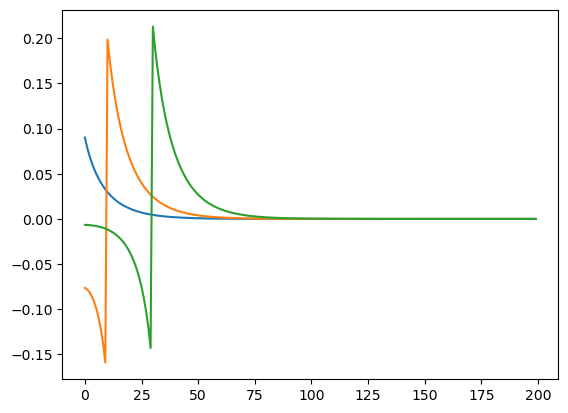

In [9]:
plt.plot(CJACR.T[0])
plt.plot(CJACR.T[10])
plt.plot(CJACR.T[30])
plt.show()

In [10]:
CJACN,AJACN = Agent.calc_jacobian('labor', 200)

No handles with labels found to put in legend.


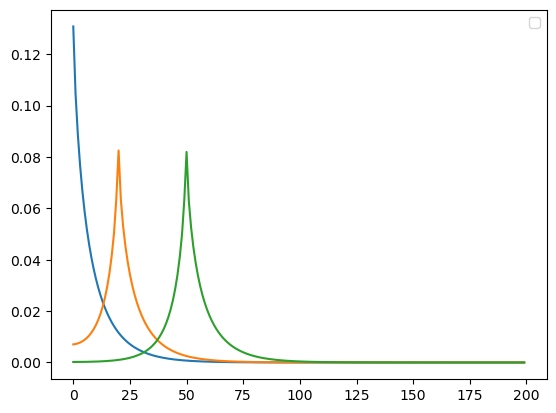

In [11]:
plt.plot(CJACN.T[0])
plt.plot(CJACN.T[20])
plt.plot(CJACN.T[50])
plt.show()

## 4. Compute General Equilibrium Steady State

In [12]:
#%% find steady state
Asset_target = B_ss
def ss_func(beta):
    Agent.DiscFac = beta
    A_ss = Agent.compute_steady_state()[0]
    
    return A_ss
    

def ss_dif(beta):
    
    return ss_func(beta) - Asset_target 


DiscFac = optimize.brentq(ss_dif,.8,.99)
print(DiscFac)


GPFRaw                 = 0.907744 
GPFNrm                 = 0.907744 
GPFAggLivPrb           = 0.902071 
Thorn = APF            = 0.907744 
PermGroFacAdj          = 1.000000 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.795000 
WRPF                   = 0.000000 
DiscFacGPFNrmMax       = 0.970874 
DiscFacGPFAggLivPrbMax = 0.976980 
GPFRaw                 = 1.009802 
GPFNrm                 = 1.009802 
GPFAggLivPrb           = 1.003491 
Thorn = APF            = 1.009802 
PermGroFacAdj          = 1.000000 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.983812 
WRPF                   = 0.000000 
DiscFacGPFNrmMax       = 0.970874 
DiscFacGPFAggLivPrbMax = 0.976980 
GPFRaw                 = 0.908524 
GPFNrm                 = 0.908524 
GPFAggLivPrb           = 0.902845 
Thorn = APF            = 0.908524 
PermGroFacAdj          = 1.000000 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.796366 
WRPF                   = 0.000000 
DiscFacGPFNrmMax    

0.9677910107381233


In [13]:
Dict['DiscFac'] = DiscFac

Agent_ss = IndShockConsumerType(**Dict, verbose = False)
#Agent.cycles = 0
#Agent.aXtraCount = 300


In [14]:
Agent_ss.solve()

In [15]:
Agent_ss.DiscFac

0.9677910107381233

In [16]:
Agent_ss.compute_steady_state()

print('beta:' +str(Agent_ss.DiscFac))
#verify
print('Assets: ' +str(Agent_ss.A_ss))
print('Asset Target:' +str(Asset_target))
print('Consumption: ' + str(Agent_ss.C_ss))
A_ss = Agent_ss.A_ss

beta:0.9677910107381233
Assets: 1.232814717942662
Asset Target:0.5
Consumption: 0.8153919448159895


## 5. Compute Jacobians with new Steady State

In [17]:
start = time.time()

CJACR_GE, AJACR_GE = Agent_ss.calc_jacobian('Rfree',200)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 4.602035760879517


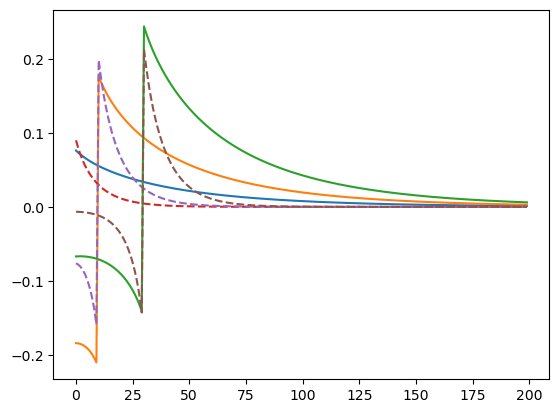

In [18]:
plt.plot(CJACR_GE.T[0])
plt.plot(CJACR_GE.T[10])
plt.plot(CJACR_GE.T[30])
plt.plot(CJACR.T[0],'--')
plt.plot(CJACR.T[10],'--')
plt.plot(CJACR.T[30],'--')
plt.show()

In [19]:
CJACN_GE, AJACN_GE = Agent_ss.calc_jacobian('labor', 200)

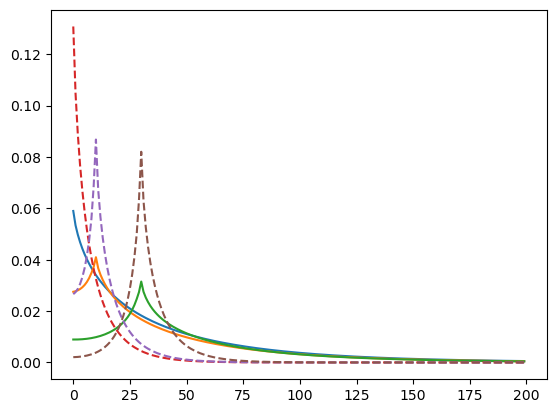

In [20]:
plt.plot(CJACN_GE.T[0])
plt.plot(CJACN_GE.T[10])
plt.plot(CJACN_GE.T[30])
plt.plot(CJACN.T[0],'--')
plt.plot(CJACN.T[10],'--')
plt.plot(CJACN.T[30],'--')
plt.show()

## 6. Set Up General Equilibrium Parts
We use here [HANK with Fiscal Policy](https://github.com/shade-econ/nber-workshop-2022/blob/main/Tutorials/Tutorial%201%20Fiscal%20Policy.ipynb). A very simple model without labor market or monetary policy

In [21]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B
    Z = Y - T
    
    deficit = G - T
    
    return T,Z, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt


### Get Household Poblem into a Block structure such that SSJ can use it
We have to include HARK Jacobians and the steady state values. Afterwards, SSJ calculates Jacobians for the GE block and creates GE Jacobians

PROBLEM: SSJ actively wants to solve for the steady state which results in errors

In [22]:
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'Z' : CJACN_GE} ,'A' : {'Z' : AJACN_GE} } )

In [23]:
HARK_SteadyState_Dict = SteadyStateDict({"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss })

In [24]:
# 1)
ss_HARK_HANK = create_model([HARK_Jacobian_Dict,fiscal,mkt_clearing], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
inputs = ['G']


Dict_HARK_HANK = {"G": 1.0, "asset_mkt":0.0, "C": C_ss,"r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }
Dict_HARK_HANK


{'G': 0.2,
 'asset_mkt': 0.0,
 'C': 0.8,
 'r': 0.030000000000000027,
 'Y': 1.0,
 'B': 0.5,
 'A': 1.232814717942662}

In [27]:
ss_HARK_HANK = ss_HARK_HANK.steady_state(Dict_HARK_HANK)

AttributeError: 'JacobianDictBlock' object has no attribute '_steady_state'

In [28]:
vars(ss_HARK_HANK)

{'M': Bijection({}),
 'steady_state_options': {},
 'impulse_nonlinear_options': {},
 'impulse_linear_options': {},
 'jacobian_options': {},
 'partial_jacobians_options': {},
 'blocks': [<SimpleBlock 'fiscal'>,
  <JacobianDictBlock outputs=['C', 'A'], inputs=['Z']>,
  <SimpleBlock 'mkt_clearing'>],
 'inmap': {'Z': OrderedSet([1]),
  'B': OrderedSet([0, 2]),
  'r': OrderedSet([0]),
  'G': OrderedSet([0, 2]),
  'Y': OrderedSet([0, 2]),
  'A': OrderedSet([2]),
  'C': OrderedSet([2])},
 'outmap': {'C': 1,
  'A': 1,
  'T': 0,
  'Z': 0,
  'deficit': 0,
  'asset_mkt': 2,
  'goods_mkt': 2},
 'adj': [OrderedSet([1]), OrderedSet([2]), OrderedSet([])],
 'revadj': [OrderedSet([]), OrderedSet([0]), OrderedSet([1])],
 'inputs': OrderedSet(['B', 'r', 'G', 'Y']),
 'outputs': OrderedSet(['C', 'A', 'T', 'Z', 'deficit', 'asset_mkt', 'goods_mkt']),
 '_required': OrderedSet(['Z', 'A', 'C']),
 'name': 'HARK_HANK',
 'kids': {'NestedDict': <JacobianDict outputs=['C', 'A'], inputs=['Z']>,
  'fiscal': <SimpleBlo

In [29]:
# 2) Create a Block with 2 dictionaries which includes steady_state
class HARK_block(Block):
    """
    The HARK block needs two ingredients.
    1. JacobianDict: A dictionary with Jacobians
    2. steady_state: A dictionary with steady state values
    """
#     def Jacobian():
#         JacobianDict( { 'C' : {'Z' : CJACN_GE} ,'A' : {'Z' : AJACN_GE} } )
    
#     def Steady_State():
#         SteadyStateDict({"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss })
        
    Jacobian = JacobianDict( { 'C' : {'Z' : CJACN_GE} ,'A' : {'Z' : AJACN_GE} } )
    Steady_State = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }
    UserProvidedSS = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }

In [32]:
HARK_Input = HARK_block
HARK_Input.Jacobian['A']

{'Z': array([[ 8.76693988e-01, -5.67620646e-02, -5.12069951e-02, ...,
          1.18308235e-04,  1.18580264e-04,  1.18841394e-04],
        [ 8.43973917e-01,  8.76693989e-01, -1.04799845e-01, ...,
          2.33589913e-04,  2.34138646e-04,  2.34665394e-04],
        [ 8.14090474e-01,  8.43973919e-01,  8.31289308e-01, ...,
          3.45918170e-04,  3.46748614e-04,  3.47545785e-04],
        ...,
        [ 1.33860975e-02,  1.36352440e-02,  1.32762649e-02, ...,
          3.61926074e-01, -5.89064987e-01, -5.51375552e-01],
        [ 1.31416635e-02,  1.33861399e-02,  1.30336454e-02, ...,
          3.45495606e-01,  3.61928618e-01, -5.89062438e-01],
        [ 1.29018091e-02,  1.31417060e-02,  1.27955763e-02, ...,
          3.30869289e-01,  3.45498105e-01,  3.61931122e-01]])}

In [33]:
ss_HARK_HANK = create_model([HARK_Input,fiscal,mkt_clearing])


AttributeError: type object 'HARK_block' has no attribute 'keys'

In [34]:
# 3) Create a Result Dictionary
class HARK_Dict(ResultDict):
#     def __init__(self):
#         self.Jacobian = JacobianDict( { 'C' : {'Z' : CJACN_GE} ,'A' : {'Z' : AJACN_GE} } )
#         self.steady_state = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }
        
    Jacobian = JacobianDict( { 'C' : {'Z' : CJACN_GE} ,'A' : {'Z' : AJACN_GE} } )
    Steady_State = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }
    UserProvidedSS = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }

In [35]:
HARK_Inputb = HARK_Dict

In [36]:
HARK_Inputb.Jacobian['A']

{'Z': array([[ 8.76693988e-01, -5.67620646e-02, -5.12069951e-02, ...,
          1.18308235e-04,  1.18580264e-04,  1.18841394e-04],
        [ 8.43973917e-01,  8.76693989e-01, -1.04799845e-01, ...,
          2.33589913e-04,  2.34138646e-04,  2.34665394e-04],
        [ 8.14090474e-01,  8.43973919e-01,  8.31289308e-01, ...,
          3.45918170e-04,  3.46748614e-04,  3.47545785e-04],
        ...,
        [ 1.33860975e-02,  1.36352440e-02,  1.32762649e-02, ...,
          3.61926074e-01, -5.89064987e-01, -5.51375552e-01],
        [ 1.31416635e-02,  1.33861399e-02,  1.30336454e-02, ...,
          3.45495606e-01,  3.61928618e-01, -5.89062438e-01],
        [ 1.29018091e-02,  1.31417060e-02,  1.27955763e-02, ...,
          3.30869289e-01,  3.45498105e-01,  3.61931122e-01]])}

In [37]:
HARK_Inputb.Steady_State

{'G': 0.2,
 'asset_mkt': 0.0,
 'C': 0.8,
 'r': 0.030000000000000027,
 'Y': 1.0,
 'B': 0.5,
 'A': 1.232814717942662}

In [38]:
ss_HARK_HANK = create_model([HARK_Inputb, fiscal, mkt_clearing])
## This error in combine comes even before

TypeError: keys() missing 1 required positional argument: 'self'

In [39]:
# 4) Use the ResultDict directly
HARK_Inputc = ResultDict(JacobianDict( { 'C' : {'Z' : CJACN_GE} ,'A' : {'Z' : AJACN_GE} } ))

AttributeError: 'JacobianDict' object has no attribute 'copy'

In [40]:
# 5) Use options for steady state
ss_HARK_HANK = create_model([HARK_Jacobian_Dict,fiscal,mkt_clearing], name="HARK_HANK")


In [41]:
vars(ss_HARK_HANK)

{'M': Bijection({}),
 'steady_state_options': {},
 'impulse_nonlinear_options': {},
 'impulse_linear_options': {},
 'jacobian_options': {},
 'partial_jacobians_options': {},
 'blocks': [<SimpleBlock 'fiscal'>,
  <JacobianDictBlock outputs=['C', 'A'], inputs=['Z']>,
  <SimpleBlock 'mkt_clearing'>],
 'inmap': {'Z': OrderedSet([1]),
  'B': OrderedSet([0, 2]),
  'r': OrderedSet([0]),
  'G': OrderedSet([0, 2]),
  'Y': OrderedSet([0, 2]),
  'A': OrderedSet([2]),
  'C': OrderedSet([2])},
 'outmap': {'C': 1,
  'A': 1,
  'T': 0,
  'Z': 0,
  'deficit': 0,
  'asset_mkt': 2,
  'goods_mkt': 2},
 'adj': [OrderedSet([1]), OrderedSet([2]), OrderedSet([])],
 'revadj': [OrderedSet([]), OrderedSet([0]), OrderedSet([1])],
 'inputs': OrderedSet(['B', 'r', 'G', 'Y']),
 'outputs': OrderedSet(['C', 'A', 'T', 'Z', 'deficit', 'asset_mkt', 'goods_mkt']),
 '_required': OrderedSet(['Z', 'A', 'C']),
 'name': 'HARK_HANK',
 'kids': {'NestedDict': <JacobianDict outputs=['C', 'A'], inputs=['Z']>,
  'fiscal': <SimpleBlo

In [51]:
ss_HARK_HANK.steady_state_options = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }

In [58]:
ss_HARK_HANK.steady_state

<bound method Block.steady_state of <Model 'HARK_HANK'>>

In [43]:
ss_HARK_HANK = ss_HARK_HANK.steady_state(Dict_HARK_HANK)

AttributeError: 'JacobianDictBlock' object has no attribute '_steady_state'

In [50]:
# 6 Add to JacobianDictBlock
ss_HARK_HANK.blocks

[<SimpleBlock 'fiscal'>,
 <JacobianDictBlock outputs=['C', 'A'], inputs=['Z']>,
 <SimpleBlock 'mkt_clearing'>]

In [61]:
ss = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }
ss_HARK_HANK.partial_jacobians(ss)

AttributeError: 'dict' object has no attribute '_vector_valued'

## Create Impulse Responses

In [53]:
G_std = 0.01
G_persistence = 0.8
T = 200
regular_Z_shock_path = {"G": G_std*G_persistence**np.arange(T)}
IPR = ss_HARK_HANK.solve_impulse_linear(ss_HARK_HANK, unknowns, targets, regular_Z_shock_path)

AttributeError: 'CombinedBlock' object has no attribute '_vector_valued'

In [ ]:
STOP

In [ ]:
# create hh
# From 

# {'backward_fun': <ExtendedFunction(hh): ['Va_p', 'a_grid', 'we', 'T', 'r', 'beta', 'eis', 'frisch', 'vphi'] -> ['Va', 'a', 'c', 'n']>, 
# 'name': 'hh', 'M': Bijection({}), 'steady_state_options': {'backward_tol': 1e-08, 'backward_maxit': 5000, 'forward_tol': 1e-10, 'forward_maxit': 100000}, 
# 'impulse_nonlinear_options': {'monotonic': False}, 'impulse_linear_options': {'h': 0.0001, 'twosided': False}, 
# 'jacobian_options': {'h': 0.0001, 'twosided': False}, 'partial_jacobians_options': {}, 'exogenous': OrderedSet(['Pi']), 'policy': OrderedSet(['a']), 
# 'backward': OrderedSet(['Va']), 'non_backward_outputs': OrderedSet(['a', 'c', 'n']), 'outputs': OrderedSet(['A', 'C', 'N']), 
# 'M_outputs': Bijection({'a': 'A', 'c': 'C', 'n': 'N'}), 'inputs': OrderedSet(['a_grid', 'we', 'T', 'r', 'beta', 'eis', 'frisch', 'vphi', 'Pi']), 
# 'internals': OrderedSet(['D', 'Dbeg', 'Pi', 'Va', 'a', 'c', 'n']), 'original_inputs': OrderedSet(['a_grid', 'we', 'T', 'r', 'beta', 'eis', 'frisch', 'vphi', 'Pi']), 
# 'original_outputs': OrderedSet(['A', 'C', 'N']), 'original_internals': OrderedSet(['D', 'Dbeg', 'Pi', 'Va', 'a', 'c', 'n']), 'original_M_outputs': Bijection({'a': 'A', 'c': 'C', 'n': 'N'}), 
# 'hetinputs': None, 'hetoutputs': None, 'backward_init': <ExtendedFunction(hh_init): ['a_grid', 'we', 'r', 'eis', 'T'] -> ['fininc', 'Va']>}


hh = {'name' : 'hh',
    'inputs' : ['a_grid', 'we', 'T', 'r', 'beta', 'eis', 'frisch', 'vphi', 'Pi'],
    'outputs' : = ['A', 'C', 'N']
    
}

In [ ]:
hh_ext = {
    inputs = OrderedSet(['r', 'beta', 'eis', 'frisch', 'vphi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Tax', 'w'])
    outputs = ['A', 'C', 'N', 'NE']
    partial_jacobians = 
    steady_state = 
}

In [ ]:
# Add Steady State.
## I found in blocks/block:
"""
    def steady_state(self, calibration: Union[SteadyStateDict, UserProvidedSS], 
                     dissolve: List[str] = [], options: Dict[str, dict] = {}, **kwargs) -> SteadyStateDict:
"""
hh_ext['UserProvidedSS'] = {}

# Step 2: General Equilibrium Part Using Sequence Space Method
Following the [SSJ](https://github.com/shade-econ/sequence-jacobian/blob/master/notebooks/hank.ipynb) and creating other market participants as simple blocks

In [ ]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return L, Div


@simple
def monetary(pi, rstar, phi):
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1
    return r


@simple
def fiscal(r, B):
    Tax = r * B
    return Tax


@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return asset_mkt, labor_mkt, goods_mkt


@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

Partial Equilibria for maro blocks

In [ ]:
## Put Blocks together
blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name="One-Asset HANK")

In [ ]:
## Steady States
ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

In [ ]:
## Solve Jacobians
## NOTE: our HARK Jacobians are already included and are just used as given
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

### a) Combining Partial Equilibrium Jacobians to make them General Equilibrium. Instead of using `CombinedBlock`

In [ ]:
J_r_rante = models['ha']['ex_post_rate'].jacobian(ss['ha'], ['r_ante'], T=T)['r']['r_ante']
J_C_r = models['ha']['hh'].jacobian(ss['ha'], ['r'], T=T)['C']['r']

dC_dr_manual = J_C_r @ J_r_rante @ dr

assert np.all(np.isclose(dC_dr['ha'], dC_dr_manual))


### b) Using linear solution methods (`impulse_linear`, `jacobian` and their `solved_` versions) at the macro model level.